***This code calculates the temporal mass uptake and spatiotemporal distribution of infiltrated inorganic species expected for a vapor phase infiltration (VPI) process, but it can likely be used to predict a variety of physicochemical processes that proceed via a combination of reaction and diffusion. These calculations are for a 1D, unidirectional diffusion gemoetry and include a non-Fickian diffusional hindering factor that scales with the concentration of reaction product.  The user must also input several other physical parameters for the polymer / vapor precursor system.***  

***Once you input the system's physical parameter, you may run each step separately (BOX 1, BOX 2, BOX 3) or can choose to "Run All" from the Runtime menu above.  At minimum, BOX 1 must be run first.  Once run, you can run BOX 2 and 3 as many times as you like, changing the plotting parameters to visualize the data in different ways.  See Appendix at bottom for definitions of the species being plotted: Cfree, Cproduct, Cpolymer, etc.***

Reference with more details: https://doi.org/10.1021/acs.chemmater.1c01283

In [ ]:
#@title BOX 1: Define Parameters and Run the Model
#@markdown ***Please first input your parameters, and then press <img src="img/button.png" width="20"> on the left to run.***
#@markdown ***Please expect to wait for about 1 - 2 minutes.***

import base64
import matplotlib.pyplot as plt
from IPython.display import display, HTML

import numpy as np
from scipy.integrate import odeint

# define TMA_PMMA model
class TMA_PMMA(object):
    """
    C + B -> S
    """

    def __init__(self, params):
        # obtain parameters for pde model
        self.l = params['l'] * 1e-4 # convert µm to cm
        self.df = params['D0']
        self.sc = params['C0surface']
        self.pc = params['C0polymer']
        self.hd = params['Kprime']
        self.k = params['k']
        self.mm = params['mm']

    def fpde(self, state, t, process):
        # obtain state information
        C, S, B = np.hsplit(state, 3)
        # compute boundary condition
        # bdC = self.sc if (t <= self.st) else max(0, self.sc * (1-(t-self.st)/60))
        bdC = self.sc if (process=='Sorption') else 0
        # compute time derivative
        fluxC = np.diff(np.concatenate(([bdC],C,[bdC]))) / np.concatenate(([self.dx/2],np.repeat(self.dx,2*self.xdim-1),[self.dx/2]))
        dCdt = self.df * np.exp(-self.hd * S) * np.diff(fluxC)/self.dx - self.k * C * B
        dSdt = self.k * C * B
        dBdt = -self.k * C * B
        return np.concatenate((dCdt,dSdt,dBdt))

    def init_states(self, xdim = 1000):
        self.xdim = xdim # level of discretization
        self.dx = self.l / self.xdim
        C = np.zeros(2 * self.xdim)
        S = np.zeros(2 * self.xdim)
        B = np.repeat(self.pc, 2 * self.xdim)
        return np.concatenate((C,S,B))

    def init_timepoints(self, endpoint):
        interval_map = [
            (0, 600, 1), # 1 second apart for first 10 minutes
            (600, 3600, 2), # 2 seconds apart for 10 - 60 minutes
            (3600, 7200, 5), # 5 seconds apart for 60 - 120 minutes
            (7200, 36000, 15), # 15 seconds apart 120 - 600 minutes
            (36000, np.inf, 30), # 30 seconds apart for > 600 minutes
        ]
        timepoints = np.array([0])
        for i in range(len(interval_map)):
            if (endpoint > interval_map[i][0]):
                start, end, step = interval_map[i]
                end = min(endpoint, end) + step
                timepoints = np.concatenate((
                    timepoints,
                    np.arange(start, end, step)[1:]
                ))
        timepoints[-1] = endpoint
        return timepoints

    def solve(self, timepoints, xdim = 500, rtol = 1.49012e-8, atol = 1.49012e-8):
         # timepoints = (sorption_time (st), desorption_time (dt))
        self.st, self.dt = timepoints
        # sorption
        self.sorption_timepoints = self.init_timepoints(self.st)
        sorption_s0 = self.init_states(xdim)
        self.sorption_states = odeint(
            self.fpde,
            sorption_s0,
            self.sorption_timepoints,
            rtol=rtol,
            atol=atol,
            args=('Sorption',)
        )
        # desorption
        self.desorption_timepoints = self.init_timepoints(self.dt)
        desorption_s0 = self.sorption_states[-1,:]
        self.desorption_states = odeint(
            self.fpde,
            desorption_s0,
            self.desorption_timepoints,
            rtol=rtol,
            atol=atol,
            args=('Desorption',)
        )

    def mass_uptake_over_time(self, return_value=False):
        normalizer = self.pc * self.l * self.mm * 1e9
        # combine sorption and desorption data
        timepoints = np.concatenate((self.sorption_timepoints, self.st+self.desorption_timepoints[1:]))
        states = np.vstack((self.sorption_states, self.desorption_states[1:,:]))
        C, S, B = [np.mean(v,1) * self.l * self.mm * 1e9 for v in np.hsplit(states,3)]
        # csv output file
        csv = 'times,Cfree,Cprod,Cpoly,normalized_Cfree,normalized_Cprod,normalized_Cpoly\n' +\
            '\n'.join(['%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e'
                        %(timepoints[i],C[i],S[i],B[i],C[i]/normalizer,S[i]/normalizer,B[i]/normalizer)
                        for i in range(timepoints.size)])
        html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
        html = html.format(
            payload=base64.b64encode(csv.encode()).decode(),
            title="Download CSV File",
            filename="temporal_mass_uptake_of_precursor_in_polymer.csv"
        )
        display(HTML(html))
        # visualization
        fig = plt.figure(figsize=(8,8), facecolor='w')
        ax1 = fig.add_subplot(211, facecolor='#dddddd', axisbelow=True)
        ax1.plot(timepoints, (C+S)/normalizer, lw=1, color='r', label='Cfree + Cprod')
        ax1.plot(timepoints, C/normalizer, lw=1, color='g', label='Cfree')
        ax1.plot(timepoints, S/normalizer, lw=1, color='b', label='Cprod')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Normalized Molar Sorption of Precursor')
        ax1.legend()
        ax2 = ax1.twinx()
        ax2.set_ylabel('Mass/Area (ng/cm^2)')
        mn, mx = ax1.get_ylim()
        ax2.set_ylim(mn*normalizer, mx*normalizer)
        plt.title('Temporal Mass Uptake of Precursor in Polymer (Linear Time)')
        ax1 = fig.add_subplot(212, facecolor='#dddddd', axisbelow=True)
        ax1.plot(np.sqrt(timepoints), (C+S)/normalizer, lw=1, color='r', label='Cfree + Cprod')
        ax1.plot(np.sqrt(timepoints), C/normalizer, lw=1, color='g', label='Cfree')
        ax1.plot(np.sqrt(timepoints), S/normalizer, lw=1, color='b', label='Cprod')
        ax1.set_xlabel('Root Time (s^0.5)')
        ax1.set_ylabel('Normalized Molar Sorption of Precursor')
        ax1.legend()
        ax2 = ax1.twinx()
        ax2.set_ylabel('Mass/Area (ng/cm^2)')
        mn, mx = ax1.get_ylim()
        ax2.set_ylim(mn*normalizer, mx*normalizer)
        plt.title('Temporal Mass Uptake of Precursor in Polymer (Root Time)')
        fig.tight_layout()
        plt.show()
        # return value
        if (return_value):
            return (C,S,B)

    def get_auto_timepoints_idx(self, process, start_timepoint, end_timepoint, number_of_timepoints = 11):
        timepoints = self.sorption_timepoints if (process=='Sorption') else self.desorption_timepoints
        start_timepoint_idx = np.argmin(np.abs(timepoints - start_timepoint))
        end_timepoint_idx = np.argmin(np.abs(timepoints - end_timepoint))
        states = self.sorption_states if (process=='Sorption') else self.desorption_states
        C, S, _ = [np.mean(v,1) for v in np.hsplit(states,3)]
        uptake = C + S
        uptake_quantiles = np.linspace(uptake[start_timepoint_idx], uptake[end_timepoint_idx], number_of_timepoints)
        timepoints_idx = np.argmin(np.abs(uptake_quantiles[:,None] - uptake), axis=1)
        return timepoints_idx

    def depth_profile(self, component, process, timepoints_type='Auto', user_input_timepoints=[], number_of_timepoints=11, return_value=False):
        # find idx for timepoints
        tps = user_input_timepoints
        if (not (isinstance(tps, list) or isinstance(tps, np.ndarray))):
            raise ValueError('user input timepoints must be a list or numpy array object.')
        if (len(tps)==2):
            start_timepoint, end_timepoint = tps[0], tps[1]
        else:
            start_timepoint = 0
            end_timepoint = self.st if (process=='Sorption') else self.dt
        timepoints = self.sorption_timepoints if (process=='Sorption') else self.desorption_timepoints
        if (timepoints_type == 'Auto'):
            timepoints_idx = self.get_auto_timepoints_idx(process, start_timepoint, end_timepoint, number_of_timepoints)
            timepoints_idx = np.unique(timepoints_idx)
            tps = timepoints[timepoints_idx]
            tps[0], tps[-1] = start_timepoint, end_timepoint
        elif (timepoints_type == 'Linear'):
            tps = np.round(np.linspace(start_timepoint, end_timepoint, number_of_timepoints)).astype('int')
            tps = np.unique(tps)
            timepoints_idx = np.argmin(np.abs(tps[:,None] - timepoints), axis=1)
        elif (timepoints_type == 'Log'):
            tps = np.round(np.exp(np.linspace(np.log(max(1e-1,start_timepoint)), np.log(max(1e-1,end_timepoint)), number_of_timepoints))).astype('int')
            tps = np.unique(tps)
            timepoints_idx = np.argmin(np.abs(tps[:,None] - timepoints), axis=1)
        elif (timepoints_type == 'Sqrt'):
            tps = np.round(np.square(np.linspace(np.sqrt(start_timepoint), np.sqrt(end_timepoint), number_of_timepoints))).astype('int')
            tps = np.unique(tps)
            timepoints_idx = np.argmin(np.abs(tps[:,None] - timepoints), axis=1)
        else: # user input timepoints
            tps = np.round(np.array(tps)).astype('int')
            timepoints_idx = np.argmin(np.abs(tps[:,None] - timepoints), axis=1)
        # find the component to visualize
        states = self.sorption_states if (process=='Sorption') else self.desorption_states
        C, S, B = np.hsplit(states[timepoints_idx,:], 3)
        if (component == 'Cfree'):
            yval = C
        elif (component == 'Cpoly'):
            yval = B
        elif (component == 'Cprod'):
            yval = S
        elif (component == 'Cfree+Cprod'):
            yval = C + S
        else:
            raise ValueError(
                "component can only be 'Cfree', 'Cpoly', 'Cprod', or 'Cfree+Cprod',"
                f"but '{component}' is provided."
            )
        yval = yval[:,:self.xdim] * self.l * self.mm * 1e9
        yval_normalizer = self.pc * self.l * self.mm * 1e9
        normalized_yval = yval / yval_normalizer
        # space dicretization value
        xval = (np.arange(self.xdim)+0.5) * self.dx
        xval = xval * 1e4 # convert from cm to µm
        # csv output file
        # Normalized Molar Sorption of Precursor
        csv_header = 'thickness(µm),' + ','.join(['%d' %tps[i] for i in range(len(tps))]) + '\n'
        csv_text = '\n'.join(['%.18e,' % xval[j] + ','.join('%18e' % normalized_yval[i,j] for i in range(len(tps))) for j in range(self.xdim)])
        csv = csv_header + csv_text
        html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
        html = html.format(
            payload=base64.b64encode(csv.encode()).decode(),
            title=f"Download CSV for {component}-{process}: Normalized Molar Sorption of Precursor",
            filename=f"{component}_{process}_normalized_mass_uptake.csv"
        )
        display(HTML(html))
        # Mass/Area (ng/cm^2)
        csv_header = 'thickness(µm),' + ','.join(['%d' %tps[i] for i in range(len(tps))]) + '\n'
        csv_text = '\n'.join(['%.18e,' % xval[j] + ','.join('%18e' % yval[i,j] for i in range(len(tps))) for j in range(self.xdim)])
        csv = csv_header + csv_text
        html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
        html = html.format(
            payload=base64.b64encode(csv.encode()).decode(),
            title=f"Download CSV for {component}-{process}: Mass/Area (ng/cm^2)",
            filename=f"{component}_{process}_absolute_mass_uptake.csv"
        )
        display(HTML(html))
        # visualization
        fig = plt.figure(figsize=(8,6), facecolor='w')
        cmap=plt.get_cmap("jet")
        ax1 = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
        for i in range(len(tps)):
            color = cmap(i/len(tps))
            ax1.plot(xval, normalized_yval[i,:], color=color, label=int(tps[i]))
        ax1.set_xlabel('Polymer Film Thickness (µm)')
        ax1.set_xlim(0, self.l * 1e4)
        ax1.set_ylabel('Normalized Molar Sorption of Precursor')
        ax1.set_ylim(-0.05 * max(0.10,np.max(normalized_yval)), 1.05 * max(0.10,np.max(normalized_yval)))
        ax1.legend(title='Time (s)')
        ax2 = ax1.twinx()
        ax2.set_ylabel('Mass/Area (ng/cm^2)')
        mn, mx = ax1.get_ylim()
        ax2.set_ylim(mn*yval_normalizer, mx*yval_normalizer)
        plt.title(f"{component} - {process}")
        plt.show()
        if (return_value):
            return yval

# @markdown **This model is based upon several physical parameters for the polymer / vapor precursor system that must be entered below, including:**

# @markdown 1. The polymer thickness (µm):
l = 0.5 # @param {type:"number"}
# @markdown 2. The initial diffusivity of the precursor in the polymer (cm^2/s):
D0 = 1.650e-10 # @param {type:"number"}
# @markdown 3. The equilibrium saturation concentration of precursors dissolved at the polymer surface (mol/cm^3):
C0surface = 4.436e-3 # @param {type:"number"}
# @markdown 4. The concentration of functional groups within the polymer that can bind or react with the precursor (mol/cm^3):
C0polymer = 5.656e-3 # @param {type:"number"}
# @markdown 5. The hindering factor for diffusivity, this parameter assumes that the precursor-polymer reaction product reduces the precursor's diffusivity in the reacted polymer regions (cm^3/mol):
Kprime = 1150 # @param {type:"number"}
# @markdown 6. The reaction rate constant for reaction between the precursor and polymer's functional groups (cm^3/mol*s):
k = 1 # @param {type:"number"}
# @markdown 7. The molar mass of the precursor (g/mol):
molarMass = 72.09 # @param {type:"number"}

# @markdown **In addition, the following 2 process conditions must be entered:**

# @markdown 8. The time of polymer exposure to the vapor precursor (sorption time, in seconds)
st = 62400 # @param {type:"number"}
# @markdown 9. The subsequent time of polymer exposed to no precursor (desorption time, in seconds)
dt = 62400 # @param {type:"number"}

# put the parameters together
model_params = {
    'l':l,
    'D0':D0,
    'C0surface':C0surface,
    'C0polymer':C0polymer,
    'Kprime':Kprime,
    'k':k,
    'mm':molarMass,
}

# call and run the model
model = TMA_PMMA(model_params)
model.solve((st,dt), xdim=500, rtol=1e-4, atol=1e-4)

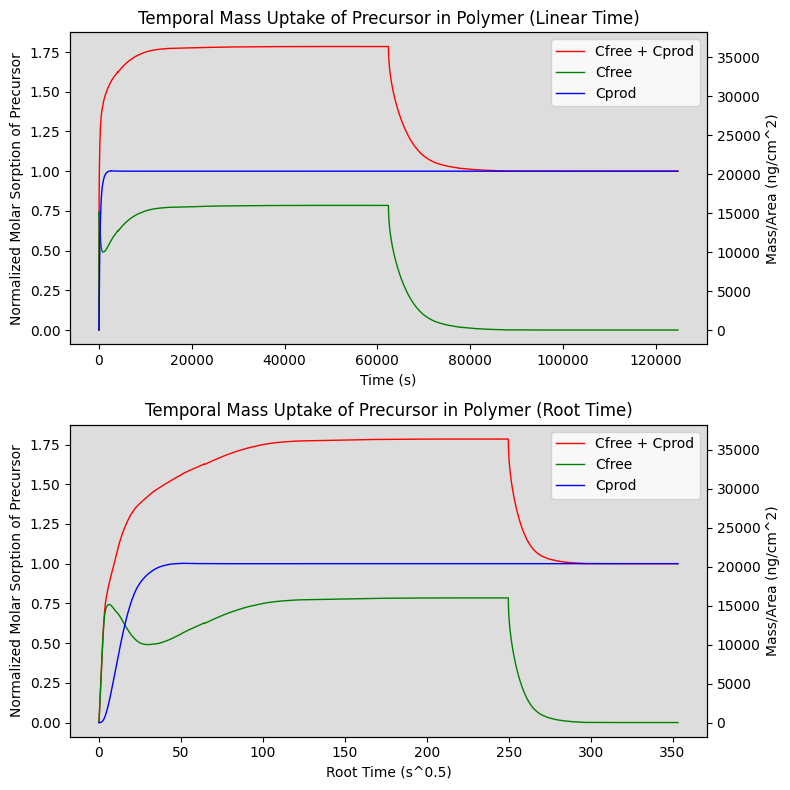

In [ ]:
#@title BOX 2: Visualization of Mass Uptake Over Time
#@markdown ***Please press <img src="img/button.png" width="20"> on the left to run.***

model.mass_uptake_over_time()

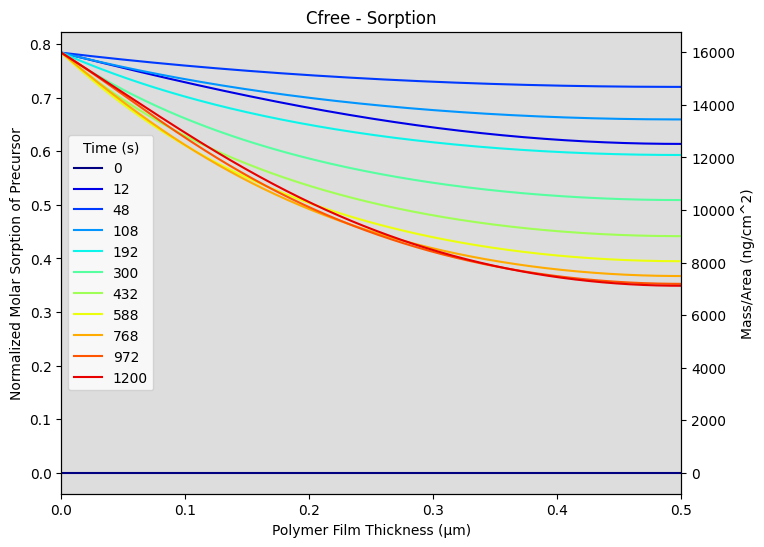

In [ ]:
#@title BOX 3: Visualization of Depth Profile
#@markdown ***Please first input your parameters, and press <img src="img/button.png" width="20"> on the left to run.***

#@markdown 1. Choose the component (Cfree, Cprod, Cpoly, Cfree+Cprod, or All) for visualization,
component = 'Cfree' # @param ['All','Cfree','Cprod','Cpoly','Cfree+Cprod']
components = ['Cfree','Cprod','Cpoly','Cfree+Cprod'] if component == 'All' else [component]

#@markdown 2. Choose the process (Sorption, Desorption or Both) for visualization,
process = 'Sorption' # @param ['Both','Sorption','Desorption']
processes = ['Sorption','Desorption'] if process == 'Both' else [process]

#@markdown 3. Select timepoints type ('Auto', 'Linear', 'Log', 'Sqrt', 'User')
timepoints_type = 'Sqrt' # @param ['Auto','Linear','Log','Sqrt','User']

#@markdown 4a. If 'Auto', 'Linear', 'Log', or 'Sqrt' timepoints type is selected,
#@markdown you can also provide the time range in the format of "start_timepoint,end_timepoint"
#@markdown to visualize the depth profile over the user specified range.
#@markdown Inputting "0,1000" in the below line shows depth profiles for time range 0 - 1000 seconds.
user_input_timerange = '0,1200' # @param {type:"string"}

#@markdown 4b. If "User" timepoints type is chosen, please provide your timepoints seperated by comma,
#@markdown e.g., "0,100,200,400,800,1600,3200,6400,12800,25600,62400".
#@markdown Note for computational efficiency,
#@markdown we only support ***timepoints*** that are 1 second apart for first 10 minutes,
#@markdown 2 seconds apart for 10 - 60 minutes,
#@markdown 5 seoncds apart for 1 - 2 hours,
#@markdown 15 seconds apart for 2 - 10 hours,
#@markdown 30 seconds apart for > 10 hours.
user_input_timepoints = '500,700,900,3000,5000,200' # @param {type:"string"}

if (timepoints_type == 'User'):
   if (user_input_timepoints == ''):
     raise ValueError('No user input timepoint is provided.')
   else:
      user_input_timepoints = [int(t.strip()) for t in user_input_timepoints.split(',')]
else:
   if (user_input_timerange == ''):
      user_input_timepoints = []
   else:
      user_input_timerange = [int(t.strip()) for t in user_input_timerange.split(',')]
      if (len(user_input_timerange) != 2):
        raise ValueError('Timerange can only take two time values, but %d are provided' %len(user_input_timerange))
      user_input_timepoints = user_input_timerange

# loop over to generate the plots
for p in processes:
    for c in components:
        model.depth_profile(
           component=c,
           process=p,
           timepoints_type=timepoints_type,
           user_input_timepoints=user_input_timepoints
         )

### Appendix

Vapor phase infiltration (VPI) is a process which infiltrates metal-organic vapors into the bulk polymer, hybridizing pure polymeric material into organic-inorganic material with enhanced properties.

According to the VPI reaction-diffusion model, a typical VPI process (one cycle) takes place in 4 steps shown below.

![vpi](https://github.com/BillHuang01/Reaction-Diffusion_Transport_Model/blob/main/img/vpi.png?raw=1)

a) The polymer is first exposed to the metal-organic precusor, instant equilibrium is reached between the polymer surface and the vapor phase metal-organic pressure. Polymer has inital free volume, and initial diffusivity.

b) When $t>0$, due to chemical potential gradient (surface concentration of metal-organic precursor is higher than bulk), metal-organic precursor will start to diffuse into the bulk of the polymer. Some of the free diffusing metal-organic precursors will react with the polymer functional groups forming immobolized product, others will keep diffusing. The formation of immobolized product will consume polymer free volume, and thus diffusivity decreases during this processes.

c) When $t>>0$, polymer is saturated with both free diffusing precursor and immbolized product. Concentration of free diffusing precusor in the bulk is same as the polymer surface, which is governed by the physical solubility between polymer and metal organic vapor. Concentration of immobolized product is governed by the inital concentration of accessible polymer functional groups and reaction rate.

d) To remove excess amount of metal-organic precursors, vacuum is applied and thus the surface concentration drops to 0. Due to change in chemical potential gradient (now bulk concentration higher than surface), free diffusing species will diffuse out of the polymer, and the immobolized product remains.

With the proposed mechanism, the model can be set up using a set of partial differential equations,

\begin{align}
  \left\{\begin{array}{l}
    \frac{\partial C_{free}}{\partial t} = D\frac{\partial^2 C_{free}}{\partial x^2} - kC_{free}C_{polymer} \\
    \frac{\partial C_{product}}{\partial t} = kC_{free}C_{polymer} \\
    D = D_0 \exp(-K^{\prime}C_{product}) \\
    \frac{\partial C_{polymer}}{\partial t} = -kC_{free}C_{polymer} \\
  \end{array}\right.
\end{align}

with the following initial and boundary conditions,

\begin{align}
  \left\{\begin{array}{lll}
    C_{free} = 0, & 0 < x < l, & t = 0 \\
    C_{product} = 0, & 0 < x < l, & t = 0 \\
    C_{polymer} = C^{0}_{polymer}, & 0 < x < l, & t = 0 \\
    \frac{\partial C_{free}}{\partial x} = 0, & x = 0, & t > 0 \\
    C_{free} = C^{0}_{surface}, & x = l, & t > 0 \\
  \end{array}\right.
\end{align}

where $C_{free}$ (mol/cm^3) is the concentration of free diffusing vapor, $k$ (cm^3/mol*s) is the reaction rate constant of a second-order reaction, $C_{polymer}$ (mol/cm^3) is the concentration of the accessible reactive polymeric functional groups, $C_{product}$ (mol/cm^3) is the concentration of the immbolized product. $D_{0}$ (cm^2/s) is the initial diffusivity, and $K^{\prime}$ (cm^3/mol) is the hindering constant related to the free volume of the polymer and the molecular size of the penetrant.

Equation 1 combines Fick's second law with a reaction term to describe the process in which the free diffusing precursor diffuses through the polymer film while being consumed by reaction. Equaiton 2 accounts for the rate of formation of immobilized product. Equation 3 assumes that diffusivity decreases exponentially with C_product. Finally Equation 4 captures the rate at which accessible reactive polymer functional groups are formed.

#### Obtaining VPI Parameters

##### Thickness $l$
Thickness was measured via spectroscopic ellipsometry as described in the experimental section.

##### Diffusivity $D_0$
The unhindered diffusion coefficient was extracted by fitting the early time portion of the TMA uptake curve to a purely Fickian model according to the steps below:
- Calculate mass per area vs. time according to the data processing steps 1-4 in section S8.
- Extract data corresponding to the TMA sorption stage.
- Normalize mass per area at each time to the total mass per area taken up in the sorption step resulting in $M_t/M_{\infty}$.
- Plot $M_t/M_{\infty}$ for the TMA sorption stage as a function of root time.
- Plot a Fickian curve using a summation from $n = 0$ to 5 and the thickness from ellipsometry. Vary the diffusion coefficient until the modeled diffusion data fits the early time mass uptake of the experimental data reasonably well.

##### Surface concentration $C_s$
Surface concentration and accessible polymer functional group density are determined from the QCM data. The maximum mass uptake at around 250 $s^{1/2}$ (35.149 μg/cm${}^{2}$) is contributed by both the free diffusing species and the immobilized reaction species. When the purge is applied, the free diffusing vapor species will desorb from the polymer film, leaving the reacted immbolized metalorganic in the film (19.7 μg/cm${}^{2}$) . Since the free diffusing mass is directly related to the surface concentration, and for free diffusing species, it is assumed that the surface concentration equals the equilibrium concentration, the surface concentration can be determined as follows:

\begin{align}
    C_{s} &= \frac{\text{Mass Contribution of free diffusing species μg/cm}{}^{2}}{\text{Thickness of membrane}} \\
    &= \frac{(35.149-19.7)\text{ μg/cm}{}^{2}}{483.1\times 10^{-7}\text{ cm}} \times \frac{10^{-6}\text{ g}}{1\text{ μg}} \times \frac{1\text{ mol}}{72.09\text{ g/mol}} = 4.436\times 10^{-3} \text{ mol/cm}{}^{3}
\end{align}

Although the mass uptake is still slowly increasing at the end of the sorption stage, this change amounts to less than one percent difference (0.2-0.3%) over the course of an hour, thus a pseudo-equilibrium can be assumed and $C_s$ can be calculated based on the QCM data at the end of sorption.

##### Accessible functional group density $C^{0}_{\text{polymer}}$
Similarly, the initial accessible polymer functional group density is also measured from the QCM, but from the mass contribution of immobilized reacted terms:

\begin{align}
    C^{0}_{\text{polymer}} &= \frac{\text{Mass Contribution of reacted species μg/cm}{}^{2}}{\text{Thickness of membrane}} \\
    &= \frac{19.7\text{ μg/cm}{}^{2}}{483.1\times 10^{-7}\text{ cm}} \times \frac{10^{-6}\text{ g}}{1\text{ μg}} \times \frac{1\text{ mol}}{72.09\text{ g/mol}} = 5.656\times 10^{-3} \text{ mol/cm}{}^{3}
\end{align}

It's important to point out that accessible functional group density, cannot be gained from stoichiometry using the polymer density and unit molecular weight. This is due to the fact that not all polymer functional groups are accessible due to steric hinderance. Even at saturation, it's possible that only half or even less of the polymer functional groups is reacted. Thus the accessible functional groups has to be gained from QCM data.

##### Hindering factor $K^{\prime}$
The hindering factor was determined based on the desorption curve., where it is assumed that only out-diffusion is happening. By utilizing the desorption curve, diffusion and reaction contributions can be deconvoluted. If hindering factor is 0, desorption will be observed as extremely fast, almost like a vertical line going down. As hindering factor is gradually increased, the desorption rate will be slower due to decrease in diffusivity and the curve will be broader. Finally, there will be a value of hindering factor which result in the modeled desorption curve similar to that of the experiment. Thus, when the hindering factor $K^{\prime}$ was fitted so that the modeled desorption rate matches with the experimental data, $K^{\prime}$ was determined to be around 1150 cm${}^{3}$/mol.

##### Reaction rate $k$
The reaction rate is the last parameter to be determined. With standard methods to obtain the 5 parameters from experiment data, the reaction rate constant $k$ is the only qualitative fit that is determined subjectively. When $k$ is around 1cm${}^{3}$/mol•s, the model qualitatively fits with the experimental data best. When k=1cm${}^{3}$/mol•s, Da has a value of 0.08. Other Da values of 0.01, 0.1, and 1 are also compared to show that k=1cm${}^{3}$/mol•s is the best fit obtained.